## Transfer learning tuning and saving best models:

### VGG16:
 * model parameter and other information can be found below:
     * [source](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
     
  * base_model: use vgg16 as base model and freeze at bottleneck layer (stop right before flatten layer). 
  * top_model: tune dense layers (parameters are inspired by the blog source):
     * batch_size 16 seems to work best for small data set 
  * freezed the first 15 layers and fined tuned the last 5 layers (block5 and fully connected layer).
  * extra blog source for callbacks and saving models:
    * [call_backs for best weights](https://machinelearningmastery.com/check-point-deep-learning-models-keras/)
    * [saving models](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)

### ResNet50:
  * Use Resnet50 to help further improve accuracy:
      * see [base model info comparison](https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5)
      * [resnet50 blog](https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33)
     
  * base_model: use RESNET50 and freeze at bottleneck layer (stop right before 2D AVERAGE POOL). 
  * top_model: tune dense layers (parameters are inspired by a few sources):
     * [source1](https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50)
     * [source2](https://www.kaggle.com/pmigdal/transfer-learning-with-resnet-50-in-keras)
     * [source3](https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8)
  * unfreezed the last 5 layers (after activation48 and fully connected layer).
  
---
#### This cell is required in order to use GPU for running the model 

In [4]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True 
# to log device placement (on which device the operation ran)
# (nothing gets printed in Jupyter, only if you run it standalone)
config.log_device_placement = False
# set this TensorFlow session as the default session for Keras                                    
sess = tf.Session(config=config)
set_session(sess) 
keras.backend.get_session().run(tf.global_variables_initializer())  

---
#### Import necessary libraries:

In [48]:
import sys
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
%matplotlib inline

#### Load in python files with helper functions:

In [6]:
%load_ext autoreload
%autoreload 1

sys.path.append("../python_files/")

import vgg16_preprocess
import model_tuning
import model_evaluation


%aimport vgg16_preprocess
%aimport model_tuning
%aimport model_evaluation

In [21]:
# import libaries
import os
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, roc_auc_score)

In [ ]:
class BaseClassifier:
    def __init__(self,label,rescale, preprocess_func, dim, modelname,modeltype, pkl='../pickle_files/pic_df.pkl'):
        self.df = pd.read_pickle(pkl)
        self.label = label
        self.rescale = rescale
        self.preprocess_func = preprocess_func
        self.dim = dim
        self.modelname = modelname
        self.modeltype = modeltype
        self.train_df = None
        self.test_df = None
        self.path1 = None
        self.path2 = None
        self.path3 = None
        self.path4 = None
        self.modelresult = None
        self.modelpath = None
        
    def create_train_test(self):
        """convert self.df into test and train pandas
       dataframe with specified classification label and test_size 
       defaults to 0.2.
        # Arguments
        # Returns
        test and train pandas dataframe with the specified classification
        label.
        """
        # subset the label dataframe
        sub_set = self.df[['pic_id',self.label]]
        X_train, X_test, y_train, y_test = train_test_split(sub_set['pic_id'],
                                                        sub_set[self.label],
                                                    stratify = sub_set[self.label],
                                                        test_size = 0.2
                                                        )
        df_train = pd.concat([X_train,y_train], axis=1)
        df_test = pd.concat([X_test,y_test], axis=1)
        return df_train, df_test
    
    def create_generator(self,train_df, test_df,shuffle,batch_size,class_mode, only_testing = False):
        """creates test and train generators for model.fit_generator.

        # Arguments
            shuffle: shuffle the data sequence for each batch generator.
            batch_size: how many images per generator.
            class_mode: None or binary in this case.
            only_testing: model testing purpose or model tuning purpose, default
            is False.
        # Returns
            generators as a tuple. If class_mode is None, creates train and test
            generators but if class_model is binary, creates train, classweights,
            and test generators.
        """
        # initialize an empty list
        generators =[]
        # only generator traingenerator if it is for model tuning
        if not only_testing:
            traingen = ImageDataGenerator(
                rescale = self.rescale,
                zoom_range= [0.8,1.7],
                shear_range=0.2,
                brightness_range=[0.5,1.5],
                rotation_range = 40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                preprocessing_function=self.preprocess_func)

            train_generator = traingen.flow_from_dataframe(
                dataframe=train_df,
                directory='../data/pics',
                x_col='pic_id',
                y_col=self.label,
                batch_size=batch_size,
                shuffle = shuffle,
                target_size=(self.dim,self.dim),
                class_mode = class_mode)
            generators.append(train_generator)
            if class_mode:
            # create classweights for train
                classweights = class_weight.compute_class_weight(
                    'balanced',np.unique(train_generator.classes),
                    train_generator.classes)
                generators.append(classweights)

        testgen = ImageDataGenerator(
            rescale = self.rescale,
            preprocessing_function=self.preprocess_func)

        test_generator = testgen.flow_from_dataframe(
            dataframe=test_df,
            directory='../data/pics',
            x_col='pic_id',
            y_col=self.label,
            batch_size=batch_size,
            shuffle=shuffle,
            target_size=(self.dim,self.dim),
            class_mode=class_mode)
        generators.append(test_generator)
        return tuple(generators)
    
    def save_bottleneck_features(self,file_path1,file_path2):
        """save output of model features from the vgg16 or resnet50 non dense
           layers as npy files in file_path1 and file_path2. Returns corresponding
           test and train df for model tuning.
        # Arguments
            file_path1: folder path to save train data npy.
            file_path2: folder path to save test data npy.
        # Returns
            train and test df for fully connected layer tuning.
        """
        # intialize the model, vgg16 or ResNet50.
        # make sure not to train the top layers.
        base_model = self.modelname(weights = 'imagenet',include_top = False)
        # generate test_train df.
        train_df, test_df = self.create_train_test()
        # update train_df and test_df
        self.train_df = train_df
        self.test_df = test_df
        # create train_generator and test_generator to get bottleneck inputs for
        # train and test df.
        # make sure shuffle is False so we know the label follows the sequence of
        # the dataframe so we can tune top_model and class_mode is None.
        generators = self.create_generator(self.train_df, self.test_df,shuffle=False,
                                  batch_size=16,class_mode=None)
        # in this case we know the class_mode is None
        train_generator, test_generator = generators
        
        # update file_path1 and file_path2
        self.file_path1 = file_path1
        self.file_path2 = file_path2

        # get features saved as .npy in file_path1 and file_path2
        bottleneck_features_train = base_model.predict_generator(
            train_generator, self.train_df.shape[0]//16)
        np.save(open(self.file_path1,'wb'),
               bottleneck_features_train)

        bottleneck_features_test = base_model.predict_generator(
            test_generator, self.test_df.shape[0]//16)
        np.save(open(self.file_path2,'wb'),
               bottleneck_features_test)
    
    def resnet50_model(self, input_shape, dropout=0.25):
        """ create dense layer for resnet50 model.
        # Arguments
            input_shape: input_shape for pooling layer.
            dropout:percentage for Dropout layer to prevent overfitting, default
            is 0.25.
        # Returns
            fully connected top model for resnet50.
        """
        model = Sequential()
        model.add(GlobalAveragePooling2D(input_shape=input_shape))
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(1,activation='sigmoid'))
        return model
    
    def vgg16_model(self, input_shape,dropout=0.5):
        """ create dense layer for vgg16 model.
        # Arguments
            input_shape: input_shape for flatten layer.
            dropout:percentage for Dropout layer to prevent overfitting, default
            is 0.5.
        # Returns
            fully connected top model for vgg16.
        """
        model = Sequential()
        model.add(Flatten(input_shape=input_shape))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def train_top_model(self, epoch, file_path3, verbose=0):
        """ train fully connected top model and save best weights to help fine
            tuning models when we unfreeze additional layers.
        # Arguments
            epoch: number of epochs in model tuning.
            file_path3: folder path to save top model best weights h5.
            verbose: show tuning progress, default is 0
        """
        # update file_path3
        self.file_path3 = file_path3
        # retrieve train and test
        train_data = np.load(open(self.file_path1,'rb'))
        # make sure train_data and train_label have same num of samples
        # convert string label to 1 or 0 for model tuning
        train_label = np.array(
        self.train_df[self.label].map({'0':0, '1':1})
        )[:-(self.train_df.shape[0]%16)]

        test_data = np.load(open(self.file_path2,'rb'))
        test_label = np.array(
            self.test_df[self.label].map({'0':0, '1':1})
        )[:-(self.test_df.shape[0]%16)]

        # build top model
        if self.modeltype == 'resnet50':
            model = self.resnet50_model(train_data.shape[1:])
        if self.modeltype == 'vgg16':
            model = self.vgg16_model(train_data.shape[1:])

        model.compile(optimizer=optimizers.Adam(),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

        # checkpoint for best weights
        checkpoint = ModelCheckpoint(self.file_path3,
            monitor='val_acc', verbose=verbose, save_best_only=True, mode='max'
            )
        callbacks_list = [checkpoint]

        _, classweight, _  = self.create_generator(self.train_df, self.test_df,False,16,
                    'binary', only_testing = False)
        
        model.fit(train_data, train_label,
                 epochs=epoch,
                 batch_size=16,
                 validation_data=(test_data,test_label),
                 callbacks=callbacks_list,
                 class_weight = classweight, verbose=verbose)
        # clears the model to enable next model tuning
        del model
        keras.backend.clear_session()


    def fine_tune_model(self, epoch, file_path4, verbose=0):
        """ Fine tunes the model in addition to the top model. Both vgg16 and
            resnet50 goes 4 layers up in addition to the dense layer.
        # Arguments
            epoch: number of epochs in model tuning.
            file_path4: folder path to save fine_tune model best weights h5.
            verbose: show progress, default is 0
        # Returns
            model results
        """
        # build model and freeze top layers
        if self.modeltype == 'resnet50':
            base_model = ResNet50(weights='imagenet',include_top=False,
                              input_shape=(self.dim,self.dim,3))
            # build top model
            top_model = self.resnet50_model(base_model.output_shape[1:],0.25)
        if self.modeltype == 'vgg16':
            base_model = VGG16(weights='imagenet',include_top=False,
                               input_shape=(self.dim,self.dim,3))
            top_model = self.vgg16_model(base_model.output_shape[1:],0.5)
        # load saved weights to fine tune parameters
        top_model.load_weights(self.file_path3)
        # add top model to model
        model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
        # we will tune last 5 layers of the model for both vgg16 and resnet50
        for layer in model.layers[:-5]:
            layer.trainable = False
        # we can tune the parameters for lr and momentum later to get better
        # results
        model.compile(loss='binary_crossentropy',
                 optimizer=optimizers.SGD(lr=5e-5, momentum = 0.9),
                 metrics=['accuracy'])
        # prepare train generator using data augmentation to battle small
        # sample size
        generators = self.create_generator(self.train_df,self.test_df,True,16,'binary')
        
        train_generator, classweight, test_generator = generators
        # checkpoint for best weights
        # update file_path4
        self.file_path4 = file_path4
        checkpoint = ModelCheckpoint(self.file_path4, monitor='val_acc', verbose=verbose,
                                save_best_only=True, mode='max')
        callbacks_list = [checkpoint]

        # run and fit model
        result = model.fit_generator(
        train_generator,
        steps_per_epoch=self.train_df.shape[0]//16,
        epochs=epoch,
        validation_data=test_generator,
        validation_steps=self.test_df.shape[0]//16,
        verbose=verbose,class_weight=list(classweight),
        callbacks=callbacks_list
        )
        self.modelresult = result
       # clears the model to enable next model tuning
        del model
        keras.backend.clear_session()
        
    def plot_model_history(self):
        """plot model accuracy and loss for test and train.
        """
        # obtain model tuning history for train and test
        model_history = self.modelresult.history
        # create plots
        # subplot 1
        plt.figure(figsize=(8,4))
        plt.subplot(1, 2, 1)
        plt.plot(model_history['val_acc'], color = 'red', label = 'test')
        plt.plot(model_history['acc'], color = 'blue', label = 'train')
        plt.title('Accuracy', size=12)
        plt.ylabel('Accuracy', size=10)
        plt.xlabel('Epoch number', size=10)
        plt.legend()
        # subplot 2
        plt.subplot(1, 2, 2)
        plt.plot(model_history['val_loss'], color = 'red', label = 'test')
        plt.plot(model_history['loss'], color = 'blue', label = 'train')
        plt.title('Loss',size=12)
        plt.ylabel('Loss', size=10)
        plt.xlabel('Epoch number', size=10)
        plt.legend()
        # show the plot
        plt.show()
        
    def save_model(self,modelpath):
        """save model as json.
        # Arguments
        modelpath: file_path to save the model as a json file
        """
        if not self.modelpath:
                self.modelpath = modelpath
        # check if the model is already saved
        if os.path.exists(self.modelpath):
            print('Model already exists')
            return 
        model = self.modelresult.model
        model_json = model.to_json()
        # serialize model to json
        with open(self.modelpath, 'w') as json_file:
            json_file.write(model_json)
            
    def model_testing(self):
        """Evaluates model on the entire pic_df. Generates confusion matrix and
           prints classification_report.
        """
        # subset the label dataframe
        sub_set = self.df[['pic_id',self.label]]
        # open and load the model
        json_file = open(self.modelpath, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load the saved model weights
        loaded_model.load_weights(self.file_path4)
        # test the entire pic_df
        generators= self.create_generator(None, self.df,False,32,'binary', True)
        
        data_generator = generators[0]
        # convert labels from string to integer for model evaluation
        labels = self.df[self.label].astype('int')
        # compile models to predict the labels
        loaded_model.compile(loss='binary_crossentropy',
                 optimizer=optimizers.SGD(),
                 metrics=['accuracy']
                        )
        # predict labels
        y_pred = np.around(loaded_model.predict_generator(data_generator,
                                                      workers=8)
                      )
        # plot ROC curve with AUC value
        fpr, tpr, thresholds = roc_curve(labels, y_pred)
        area = roc_auc_score(labels, y_pred)
        plt.title(f'Receiver Operating Characteristic for {self.modeltype}_{self.label}')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % area)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        cm = confusion_matrix(labels, y_pred)
        print(pd.DataFrame(cm, index=['True_0','True_1'],
                       columns=['Pred_0','Pred_1']))
        print(classification_report(labels, y_pred))      

----
#### Train VGG16 models, save the best weights and show results
* set file_paths and preprocess functions for hat, beard, and eyewear:

In [23]:
file_path1_hat = '../tuning_data/VGG_16_tuning/bottleneck_train_hat.npy'
file_path2_hat = '../tuning_data/VGG_16_tuning/bottleneck_test_hat.npy'
file_path3_hat = '../tuning_data/VGG_16_tuning/top_model_weights_hat.h5'
file_path4_hat = '../tuning_data/VGG_16_tuning/best_vgg16_model_hattest.h5'
file_path1_beard = '../tuning_data/VGG_16_tuning/bottleneck_train_beard.npy'
file_path2_beard = '../tuning_data/VGG_16_tuning/bottleneck_test_beard.npy'
file_path3_beard = '../tuning_data/VGG_16_tuning/top_model_weights_beard.h5'
file_path4_beard = '../tuning_data/VGG_16_tuning/best_vgg16_model_beardtest.h5'
file_path1_eyewear = '../tuning_data/VGG_16_tuning/bottleneck_train_eyewear.npy'
file_path2_eyewear = '../tuning_data/VGG_16_tuning/bottleneck_test_eyewear.npy'
file_path3_eyewear = '../tuning_data/VGG_16_tuning/top_model_weights_eyewear.h5'
file_path4_eyewear = '../tuning_data/VGG_16_tuning/best_vgg16_model_eyeweartest.h5'
rescale_v = 1./255
process_func_v = vgg16_preprocess.preprocess_input
dim_v = 150
vgg16_model_path = '../tuning_data/VGG_16_tuning/vgg_modeltest.json'

In [85]:
beard_resnet = BaseClassifier('beard',rescale_r,process_input_r,dim_r,ResNet50,'resnet50')

In [86]:
beard_resnet.save_bottleneck_features(file_path1_beard,file_path2_beard)

W0909 22:40:00.867984 139721468995392 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



Found 522 validated image filenames.
Found 131 validated image filenames.


In [87]:
beard_resnet.train_top_model(20,file_path3_beard,verbose=0)

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


In [89]:
beard_resnet.fine_tune_model(20,file_path4_beard)

Found 522 validated image filenames belonging to 2 classes.
Found 131 validated image filenames belonging to 2 classes.


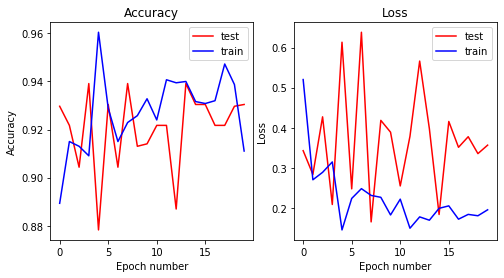

In [93]:
beard_resnet.plot_model_result()

In [91]:
beard_resnet.save_model(resnet_model_path)

Found 653 validated image filenames belonging to 2 classes.


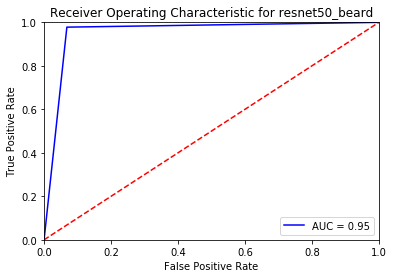

        Pred_0  Pred_1
True_0     397      29
True_1       5     222
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       426
           1       0.88      0.98      0.93       227

    accuracy                           0.95       653
   macro avg       0.94      0.95      0.94       653
weighted avg       0.95      0.95      0.95       653



In [94]:
beard_resnet.model_testing()

* save and create test and train df for hat, beard, and eyewear for vgg16:

In [5]:
train_df_hat_v, test_df_hat_v  = model_tuning.save_bottleneck_features('hat',VGG16,process_func_v,1./255,(150,150),
                                                                       file_path1_hat, file_path2_hat)
train_df_beard_v, test_df_beard_v  = model_tuning.save_bottleneck_features('beard',VGG16,process_func_v,1./255,
                                                                           (150,150), file_path1_beard,
                                                                           file_path2_beard)
train_df_eyewear_v, test_df_eyewear_v  = model_tuning.save_bottleneck_features('eyewear',VGG16,process_func_v,
                                                                               1./255,(150,150),
                                                                               file_path1_eyewear,
                                                                               file_path2_eyewear)

* quickly train top models and save best weights for model fine tuning:

In [6]:
# hat
print('Tuning vgg16 hat:')
model_tuning.train_top_model(train_df_hat_v, test_df_hat_v,50, 'hat', 'vgg16',
                             1./255, process_func_v, (150,150),
                             file_path1_hat,file_path2_hat, file_path3_hat)
# beard
print('\n\nTuning vgg16 beard:')
model_tuning.train_top_model(train_df_beard_v,test_df_beard_v,50, 'beard', 'vgg16',
                             1./255, process_func_v, (150,150),
                             file_path1_beard, file_path2_beard, file_path3_beard)
# eyewear
print('\n\nTuning vgg16 eyewear:')
model_tuning.train_top_model(train_df_eyewear_v,test_df_eyewear_v, 50, 'eyewear','vgg16',
                             1./2255, process_func_v, (150,150),
                             file_path1_eyewear, file_path2_eyewear, file_path3_eyewear)

* fine tune models and save best weights for final model

In [7]:
# hat
print('Tuning vgg16 hat:')
model_result_hat = model_tuning.fine_tune_model(train_df_hat_v,test_df_hat_v,50,'hat','vgg16',
                                150,1./255,process_func_v,file_path3_hat, file_path4_hat)
# beard
print('\n\nTuning vgg16 beard:')
model_result_beard = model_tuning.fine_tune_model(train_df_beard_v,test_df_beard_v,50,'beard','vgg16',
                                150,1./255,process_func_v,file_path3_beard, file_path4_beard)
# eyewear
print('\n\nTuning vgg16 eyewear:')
model_result_eyewear = model_tuning.fine_tune_model(train_df_eyewear_v,test_df_eyewear_v,50,'eyewear','vgg16',
                                150,1./255,process_func_v,file_path3_eyewear, file_path4_eyewear)

* save model, we only need to save one model as they are the same model architecture:

In [8]:
model_evaluation.save_model(model_result_hat, vgg16_model_path)

* plot model accuracy and loss curves with each epoch:

In [13]:
# hat
print('Check vgg16 hat model result:')
model_evaluation.plot_model_result(model_result_hat)
# beard
print('\n\n Check vgg16 beard model result:')
model_evaluation.plot_model_result(model_result_beard)
# eyewear
print('\n\n Check vgg16 eyewear model result:')
model_evaluation.plot_model_result(model_result_eyewear)

* test model on entire pic_df

vgg16 hat model evaluation:


W0908 20:37:46.435916 140299869275968 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0908 20:37:46.440665 140299869275968 deprecation.py:323] From /home/mindy/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Found 653 validated image filenames belonging to 2 classes.


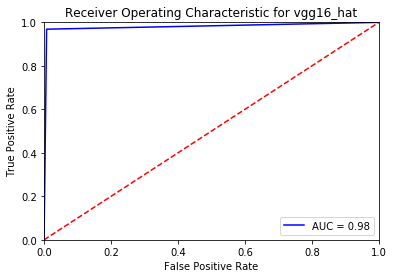

        Pred_0  Pred_1
True_0     395       3
True_1       8     247
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       398
           1       0.99      0.97      0.98       255

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



vgg16 beard model evaluation:
Found 653 validated image filenames belonging to 2 classes.


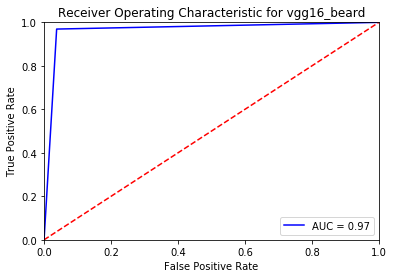

        Pred_0  Pred_1
True_0     410      16
True_1       7     220
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       426
           1       0.93      0.97      0.95       227

    accuracy                           0.96       653
   macro avg       0.96      0.97      0.96       653
weighted avg       0.97      0.96      0.96       653



vgg16 eyewear model evaluation:
Found 653 validated image filenames belonging to 2 classes.


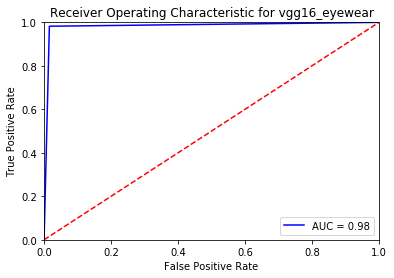

        Pred_0  Pred_1
True_0     311       5
True_1       6     331
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       316
           1       0.99      0.98      0.98       337

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



In [15]:
 # hat
print('vgg16 hat model evaluation:')
model_evaluation.model_testing(pickle_file_path,'hat',vgg16_model_path,file_path4_hat,
                              (150,150),1./255,process_func_v, 'vgg16')
# beard
print('\n\nvgg16 beard model evaluation:')
model_evaluation.model_testing(pickle_file_path, 'beard', vgg16_model_path, file_path4_beard,
                              (150,150),1./255, process_func_v, 'vgg16')
# eyewear
print('\n\nvgg16 eyewear model evaluation:')
model_evaluation.model_testing(pickle_file_path, 'eyewear', vgg16_model_path, file_path4_eyewear,
                              (150,150),1./255, process_func_v, 'vgg16')

----
#### Train resnet50 models, save the best weights and show results:
* set file_paths for hat, beard, and eyewear:

In [84]:
# set file_pathsand preprocess functions for hat, beard, and eyewear
file_path1_hat = '../tuning_data/resnet_data/bottleneck_train_hat.npy'
file_path2_hat = '../tuning_data/resnet_data/bottleneck_test_hat.npy'
file_path3_hat = '../tuning_data/resnet_data/top_model_weights_hat.h5'
file_path4_hat = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_hattest.h5'
file_path1_beard = '../tuning_data/resnet_data/bottleneck_train_beard.npy'
file_path2_beard = '../tuning_data/resnet_data/bottleneck_test_beard.npy'
file_path3_beard = '../tuning_data/resnet_data/top_model_weights_beard.h5'
file_path4_beard = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_beardtest.h5'
file_path1_eyewear = '../tuning_data/resnet_data/bottleneck_train_eyewear.npy'
file_path2_eyewear = '../tuning_data/resnet_data/bottleneck_test_eyewear.npy'
file_path3_eyewear = '../tuning_data/resnet_data/top_model_weights_eyewear.h5'
file_path4_eyewear = '../tuning_data/resnet_data/untracked_resnet50/best_resnet50_model_eyeweartest.h5'
resnet_model_path = '../tuning_data/resnet_data/resnet50_model_5_uptest.json'
rescale_r = None
process_input_r = preprocess_input
dim_r = 224

* save and create test and train df for hat, beard, and eyewear for resnet50:

In [17]:
train_df_hat_r, test_df_hat_r  = model_tuning.save_bottleneck_features('hat',ResNet50,preprocess_input,None,
                                                                       (224,224),file_path1_hat, file_path2_hat)
train_df_beard_r, test_df_beard_r  = model_tuning.save_bottleneck_features('beard',ResNet50,preprocess_input,None,
                                                                           (224,224), file_path1_beard,
                                                                           file_path2_beard)
train_df_eyewear_r, test_df_eyewear_r  = model_tuning.save_bottleneck_features('eyewear',ResNet50,preprocess_input,
                                                                               None,(224,224),
                                                                               file_path1_eyewear,
                                                                               file_path2_eyewear)

* quickly train top models and save best weights for model fine tuning:

In [18]:
# hat
print('Tuning resnet50 hat:')
model_tuning.train_top_model(train_df_hat_r, test_df_hat_r,50, 'hat', 'resnet50',
                             None, preprocess_input,(224,224),
                             file_path1_hat,file_path2_hat, file_path3_hat)
# beard
print('\n\nTuning resnet50 beard:')
model_tuning.train_top_model(train_df_beard_r, test_df_beard_r,50, 'beard', 'resnet50',
                             None, preprocess_input,(224,224),
                             file_path1_beard, file_path2_beard, file_path3_beard)
# eyewear
print('\n\nTuning resnet50 eyewear:')
model_tuning.train_top_model(train_df_eyewear_r,test_df_eyewear_r, 50, 'eyewear','resnet50',
                              None, preprocess_input,(224,224),
                             file_path1_eyewear, file_path2_eyewear, file_path3_eyewear)

* fine tune models and save best weights for final model:

In [19]:
# hat
print('Tuning resnet50 hat:')
model_result_hat = model_tuning.fine_tune_model(train_df_hat_r,test_df_hat_r,50,'hat','resnet50',
                                224,None,preprocess_input,file_path3_hat, file_path4_hat)
# beard
print('\n\nTuning resnet50 beard:')
model_result_beard = model_tuning.fine_tune_model(train_df_beard_r,test_df_beard_r,50,'beard','resnet50',
                                224,None,preprocess_input,file_path3_beard, file_path4_beard)
# eyewear
print('\n\nTuning resnet50 eyewear:')
model_result_eyewear = model_tuning.fine_tune_model(train_df_eyewear_r,test_df_eyewear_r,50,'eyewear','resnet50',
                                224,None,preprocess_input, file_path3_eyewear, file_path4_eyewear)

* save model, we only need to save one model as they are the same model architecture:

In [20]:
model_evaluation.save_model(model_result_hat, resnet_model_path)

* plot model accuracy and loss curves with each epoch:

In [21]:
# hat
print('Check resnet hat model result:')
model_evaluation.plot_model_result(model_result_hat)
# beard
print('\n\n Check resnet beard model result:')
model_evaluation.plot_model_result(model_result_beard)
# eyewear
print('\n\n Check resnet eyewear model result:')
model_evaluation.plot_model_result(model_result_eyewear)

* test model on entire pic_df:

W0908 20:43:35.258756 140299869275968 deprecation_wrapper.py:119] From /home/mindy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.



resnet50 hat model evaluation:
Found 653 validated image filenames belonging to 2 classes.


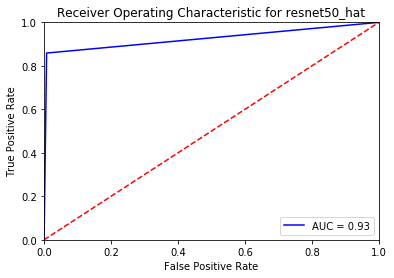

        Pred_0  Pred_1
True_0     395       3
True_1      36     219
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       398
           1       0.99      0.86      0.92       255

    accuracy                           0.94       653
   macro avg       0.95      0.93      0.94       653
weighted avg       0.94      0.94      0.94       653



resnet50 beard model evaluation:
Found 653 validated image filenames belonging to 2 classes.


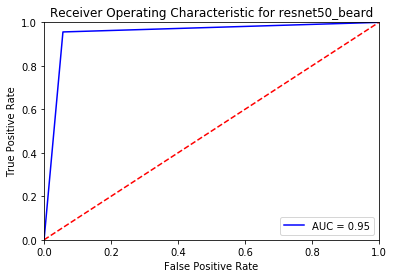

        Pred_0  Pred_1
True_0     402      24
True_1      10     217
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       426
           1       0.90      0.96      0.93       227

    accuracy                           0.95       653
   macro avg       0.94      0.95      0.94       653
weighted avg       0.95      0.95      0.95       653



resnet50 eyewear model evaluation:
Found 653 validated image filenames belonging to 2 classes.


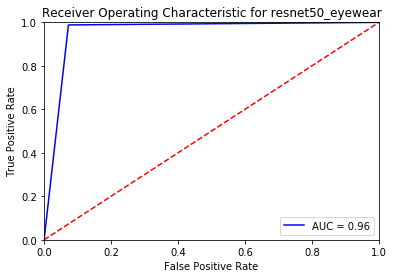

        Pred_0  Pred_1
True_0     293      23
True_1       4     333
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       316
           1       0.94      0.99      0.96       337

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



In [22]:
# hat
print('resnet50 hat model evaluation:')
model_evaluation.model_testing(pickle_file_path,'hat',resnet_model_path,file_path4_hat,
                              (224,224),None,preprocess_input, 'resnet50')
# beard
print('\n\nresnet50 beard model evaluation:')
model_evaluation.model_testing(pickle_file_path, 'beard', resnet_model_path, file_path4_beard,
                              (224,224),None,preprocess_input, 'resnet50')
# eyewear
print('\n\nresnet50 eyewear model evaluation:')
model_evaluation.model_testing(pickle_file_path, 'eyewear', resnet_model_path, file_path4_eyewear,
                              (224,224),None,preprocess_input, 'resnet50')